# 1. Import Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import dataframe_image as dfi
import shap
import time

import xgboost as xgb

from xgboost import XGBClassifier

from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score

from sklearn.preprocessing import LabelEncoder 

from mlxtend.plotting import plot_confusion_matrix

from ydata_profiling import ProfileReport

numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.


# 2. Import the Data

In [2]:
df = pd.read_csv('bank-additional-full.csv', delimiter = ';')
df.head()

age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0          93.994          -36.4      4.857       5191.0  no  
1          93.994          -36.4      4.857       5191.0  no  
2          93.994          -36.4      4.857       5191.0  no  
3          93.994          -36.4      4.857       5191.0  no  
4          93.994          -36.4      4.857       5191.0  no  

[5 rows x 21 columns]

In [3]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [4]:
# Drop the unnecessary columns

df.drop(['contact', 'month', 'day_of_week', 'poutcome', 'duration'], axis = 1, inplace = True)
df.head()

age        job  marital    education  default housing loan  campaign  \
0   56  housemaid  married     basic.4y       no      no   no         1   
1   57   services  married  high.school  unknown      no   no         1   
2   37   services  married  high.school       no     yes   no         1   
3   40     admin.  married     basic.6y       no      no   no         1   
4   56   services  married  high.school       no      no  yes         1   

   pdays  previous  emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
0    999         0           1.1          93.994          -36.4      4.857   
1    999         0           1.1          93.994          -36.4      4.857   
2    999         0           1.1          93.994          -36.4      4.857   
3    999         0           1.1          93.994          -36.4      4.857   
4    999         0           1.1          93.994          -36.4      4.857   

   nr.employed   y  
0       5191.0  no  
1       5191.0  no  
2       5191.0  no  
3       5191.0  no  
4       5191.0  no

# 3. Utility Functions

In [5]:
def return_categorical(df):

    categorical_columns = [column_name for column_name in df if df[column_name].dtype == 'O']
    return categorical_columns

def check_unique_values(columns):
    for i in columns:
        print("Column name :", i,'\n', df[i].unique())
        print()

# 4. Explanatory Data Analysis

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   campaign        41188 non-null  int64  
 8   pdays           41188 non-null  int64  
 9   previous        41188 non-null  int64  
 10  emp.var.rate    41188 non-null  float64
 11  cons.price.idx  41188 non-null  float64
 12  cons.conf.idx   41188 non-null  float64
 13  euribor3m       41188 non-null  float64
 14  nr.employed     41188 non-null  float64
 15  y               41188 non-null  object 
dtypes: float64(5), int64(4), object(7)
memory usage: 5.0+ MB


In [7]:
df.describe(include = "object").T

count unique                top   freq
job        41188     12             admin.  10422
marital    41188      4            married  24928
education  41188      8  university.degree  12168
default    41188      3                 no  32588
housing    41188      3                yes  21576
loan       41188      3                 no  33950
y          41188      2                 no  36548

In [8]:
df.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
campaign            int64
pdays               int64
previous            int64
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

In [9]:
profile = ProfileReport(df, title="Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<Axes: >

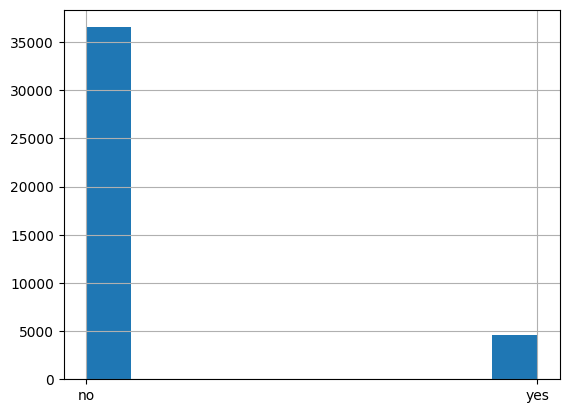

In [10]:
df["y"].hist()

**We have an imbalanced dataset**

In [11]:
# We can set 999 values in pdays column to 0

df.loc[(df['pdays'] == 999), 'pdays'] = 0

In [12]:
# Check
df['pdays'].unique()

array([ 0,  6,  4,  3,  5,  1, 10,  7,  8,  9, 11,  2, 12, 13, 14, 15, 16,
       21, 17, 18, 22, 25, 26, 19, 27, 20], dtype=int64)

In [13]:
# Check the unique values in each categorical features
check_unique_values(return_categorical(df))

Column name : job 
 ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']

Column name : marital 
 ['married' 'single' 'divorced' 'unknown']

Column name : education 
 ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']

Column name : default 
 ['no' 'unknown' 'yes']

Column name : housing 
 ['no' 'yes' 'unknown']

Column name : loan 
 ['no' 'yes' 'unknown']

Column name : y 
 ['no' 'yes']



In [14]:
# Set "unknown" values to np.nan. XGBoost and LightGBM will handle missing data.
for i in return_categorical(df):
    
    df.loc[(df[i] == "unknown") , i] = np.nan

In [15]:
# Check the unique values in each categorical features. There are missing values flaged as "unknown"
check_unique_values(return_categorical(df))

Column name : job 
 ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' nan 'entrepreneur' 'student']

Column name : marital 
 ['married' 'single' 'divorced' nan]

Column name : education 
 ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course' nan
 'university.degree' 'illiterate']

Column name : default 
 ['no' nan 'yes']

Column name : housing 
 ['no' 'yes' nan]

Column name : loan 
 ['no' 'yes' nan]

Column name : y 
 ['no' 'yes']



In [21]:
#Percentage of missing values
pd.DataFrame((df.isnull().sum()/len(df))*100, columns=['Percentage of missing values'])

Percentage of missing values
age                                 0.000000
job                                 0.801204
marital                             0.194231
education                           4.202680
default                            20.872584
housing                             2.403613
loan                                2.403613
campaign                            0.000000
pdays                               0.000000
previous                            0.000000
emp.var.rate                        0.000000
cons.price.idx                      0.000000
cons.conf.idx                       0.000000
euribor3m                           0.000000
nr.employed                         0.000000
y                                   0.000000

# 5.1 Format the Data: Split into Features and Target  

In [22]:
# Label Encoding for target variable

le = LabelEncoder()
df['y']= le.fit_transform(df['y'])
df.head()

age        job  marital    education default housing loan  campaign  pdays  \
0   56  housemaid  married     basic.4y      no      no   no         1      0   
1   57   services  married  high.school     NaN      no   no         1      0   
2   37   services  married  high.school      no     yes   no         1      0   
3   40     admin.  married     basic.6y      no      no   no         1      0   
4   56   services  married  high.school      no      no  yes         1      0   

   previous  emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
0         0           1.1          93.994          -36.4      4.857   
1         0           1.1          93.994          -36.4      4.857   
2         0           1.1          93.994          -36.4      4.857   
3         0           1.1          93.994          -36.4      4.857   
4         0           1.1          93.994          -36.4      4.857   

   nr.employed  y  
0       5191.0  0  
1       5191.0  0  
2       5191.0  0  
3       5191.0  0  
4       5191.0  0

In [23]:
df['y'].unique()

array([0, 1])

In [24]:
X = df.drop(['y'], axis = 1).copy()
X.head()

age        job  marital    education default housing loan  campaign  pdays  \
0   56  housemaid  married     basic.4y      no      no   no         1      0   
1   57   services  married  high.school     NaN      no   no         1      0   
2   37   services  married  high.school      no     yes   no         1      0   
3   40     admin.  married     basic.6y      no      no   no         1      0   
4   56   services  married  high.school      no      no  yes         1      0   

   previous  emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
0         0           1.1          93.994          -36.4      4.857   
1         0           1.1          93.994          -36.4      4.857   
2         0           1.1          93.994          -36.4      4.857   
3         0           1.1          93.994          -36.4      4.857   
4         0           1.1          93.994          -36.4      4.857   

   nr.employed  
0       5191.0  
1       5191.0  
2       5191.0  
3       5191.0  
4       5191.0

In [25]:
y = df['y'].copy()
y.head()

0    0
1    0
2    0
3    0
4    0
Name: y, dtype: int32

# 5.2 Formatting the Data : Set Categorical Features to use enable_categorical

**One-hot encoding won't be used in this case study. Instead, enable_categorical = True will be used. XGBoost will handle categorical variables. Note : enable_categorical is still experimental.**

In [26]:
X_encoded = X.copy()

In [29]:
# We need to change the datatype from object to category to be able to use enable_categorical parameter
for i in return_categorical(df):
    
    X_encoded[i] = X_encoded[i].astype("category")

In [30]:
X_encoded.dtypes

age                  int64
job               category
marital           category
education         category
default           category
housing           category
loan              category
campaign             int64
pdays                int64
previous             int64
emp.var.rate       float64
cons.price.idx     float64
cons.conf.idx      float64
euribor3m          float64
nr.employed        float64
dtype: object

# 6.Preliminary XGBoost Model

In [31]:
# Train- Test Splits. As we have an imbalanced dataset, we should use stratified sampling

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size = 0.2, random_state = 42, stratify = y)

In [32]:
# Create validation set

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 42, stratify = y_train)

In [33]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape:{X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape:{X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (29655, 15)
y_train shape: (29655,)
X_val shape:(3295, 15)
y_val shape: (3295,)
X_test shape:(8238, 15)
y_test shape: (8238,)


In [34]:
# As seen, the ratio is same for train, validation, and test sets
print(f"Ratio in train data: {sum(y_train) / len(y_train)*100:0.2f}")
print(f"Ratio in valid data: {sum(y_val) / len(y_val)*100:0.2f}")
print(f"Ratio in test data: {sum(y_test) / len(y_test)*100:0.2f}")

Ratio in train data: 11.27
Ratio in valid data: 11.26
Ratio in test data: 11.26


In [35]:
# We need to approx tree method to be able to use enable_categorical parameters. It does not work with exact tree method
clf_xgb = XGBClassifier(tree_method = "approx",
                        objective = 'binary:logistic',
                        eval_metric = 'auc',
                        enable_categorical = True,
                        missing = np.nan,
                        seed = 42)
clf_xgb.fit(X_train,
            y_train,
            verbose = False,
            eval_set = [(X_val,y_val)])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [38]:
# Confusion Matrix
%matplotlib inline
y_pred = clf_xgb.predict(X_test)
labels = ['Not deposited','Deposited' ]
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, figsize=(8, 8), show_normed = True,class_names=labels)
plt.show()

In [37]:
# We can see that the model detects only 26% percent of customer who deposited. Accuracy is 90%, but
# False negative is still high. We need to increase F-1 score.
print(classification_report(y_test, y_pred, target_names=labels))

               precision    recall  f1-score   support

Not deposited       0.91      0.98      0.94      7310
    Deposited       0.60      0.26      0.36       928

     accuracy                           0.90      8238
    macro avg       0.75      0.62      0.65      8238
 weighted avg       0.88      0.90      0.88      8238



# 7.RandomizedSearchCV for hyperparameter tuning for XGBoost Model

In [39]:
start = time.time()

params = {'n_estimators'  : [100,200,500,1000,5000],
          'learning_rate' : [0.001,0.01,0.05, 0.1, 0.2, 0.3],
          'max_depth' : range(3,10,1),
          'gamma' : [0, 0.25, 1.0, 2.0, 2.5],
          'reg_lambda' : [0, 1.0, 10.0, 20.0],
          'reg_alpha' : [0, 1.0, 10.0, 20.0],
          'scale_pos_weight' : [1, 3, 3.5, 4, 5, 8, 10],
          'subsample' : [0.5,0.7,0.8],
         }
estimator = XGBClassifier(tree_method = "approx",
                          objective = 'binary:logistic',
                          enable_categorical = True,
                          missing = np.nan,
                          seed = 42)

random_cv = RandomizedSearchCV(estimator = estimator, param_distributions = params, scoring = 'roc_auc', cv = 5, n_iter = 50, verbose=0)
random_cv.fit(X_train, y_train)


print(f"Time elapsed-XGBoost: {(time.time() - start) / 60:.2f} min")

Time elapsed-XGBoost: 19.04 min


In [40]:
random_cv.best_params_

{'subsample': 0.8,
 'scale_pos_weight': 3.5,
 'reg_lambda': 0,
 'reg_alpha': 0,
 'n_estimators': 100,
 'max_depth': 5,
 'learning_rate': 0.05,
 'gamma': 1.0}

In [41]:
#Tuned Model

clf_xgb_tuned = XGBClassifier(
                        tree_method = "approx",
                        n_estimators = random_cv.best_params_['n_estimators'],
                        gamma = random_cv.best_params_['gamma'],
                        learning_rate = random_cv.best_params_['learning_rate'],
                        max_depth = random_cv.best_params_['max_depth'],
                        reg_lambda = random_cv.best_params_['reg_lambda'],
                        reg_alpha = random_cv.best_params_['reg_alpha'],
                        scale_pos_weight = random_cv.best_params_['scale_pos_weight'],
                        booster = 'gbtree',
                        objective = 'binary:logistic',
                        eval_metric = 'auc',
                        early_stopping_rounds = 10,
                        subsample = random_cv.best_params_['subsample'],
                        enable_categorical = True,
                        missing = np.nan,
                        seed = 42)
clf_xgb_tuned.fit(X_train,
                  y_train,
                  verbose = False,
                  eval_set = [(X_val,y_val)])

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=10,
              enable_categorical=True, eval_metric='auc', feature_types=None,
              gamma=1.0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [107]:
# Confusion Matrix
%matplotlib inline
y_pred_xgb = clf_xgb_tuned.predict(X_test)
labels = ['Not deposited','Deposited']
cm = confusion_matrix(y_test, y_pred_xgb)
plot_confusion_matrix(cm, figsize=(8, 8), show_normed = True, class_names=labels)
plt.title("XGBoost")
plt.show()

In [44]:
# After hyperparameter tuning, recall increased to 59 percent and accuracy decreased from 90% to 88%. F-1 score 
# increased from 0.65 to 0.72. This is definitely better model.
print(classification_report(y_test, y_pred_xgb, target_names=labels))

               precision    recall  f1-score   support

Not deposited       0.95      0.91      0.93      7310
    Deposited       0.46      0.59      0.52       928

     accuracy                           0.88      8238
    macro avg       0.70      0.75      0.72      8238
 weighted avg       0.89      0.88      0.88      8238



# 8. Preliminary LightGBM Model

In [45]:
X_train.dtypes

age                  int64
job               category
marital           category
education         category
default           category
housing           category
loan              category
campaign             int64
pdays                int64
previous             int64
emp.var.rate       float64
cons.price.idx     float64
cons.conf.idx      float64
euribor3m          float64
nr.employed        float64
dtype: object

In [47]:
clf_lgb = LGBMClassifier(objective = 'binary',
                         use_missing = True,
                         seed = 42)
clf_lgb.fit(X_train,
            y_train,
            eval_metric = 'auc',
            categorical_feature = "auto",
            eval_set = [(X_val,y_val)])

[LightGBM] [Info] Number of positive: 3341, number of negative: 26314
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001555 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 449
[LightGBM] [Info] Number of data points in the train set: 29655, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.112662 -> initscore=-2.063831
[LightGBM] [Info] Start training from score -2.063831


LGBMClassifier(objective='binary', seed=42, use_missing=True)

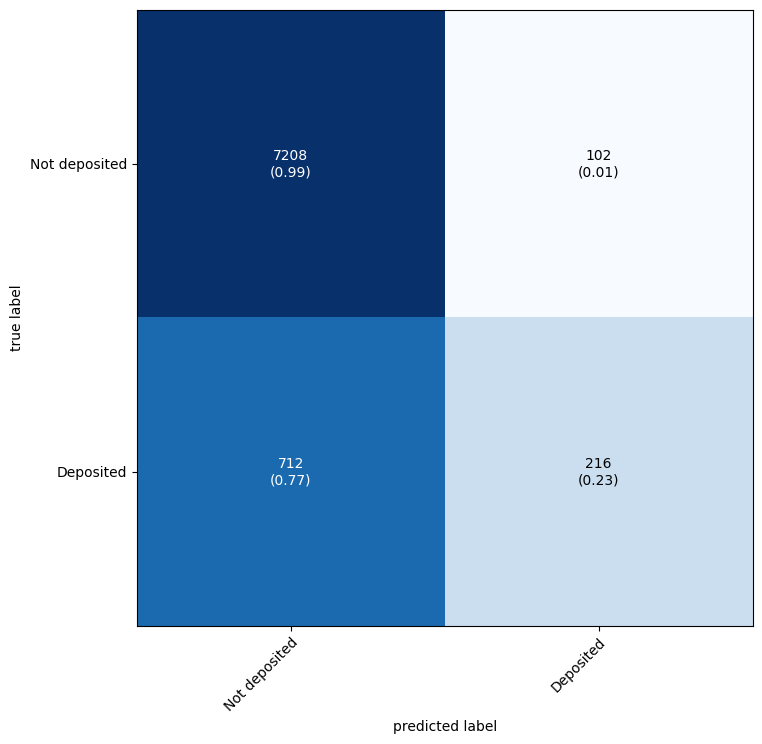

In [51]:
# Confusion Matrix
%matplotlib inline
y_pred_lgb = clf_lgb.predict(X_test)
labels = ['Not deposited','Deposited']
cm = confusion_matrix(y_test, y_pred_lgb)
plot_confusion_matrix(cm, figsize=(8, 8), show_normed = True, class_names=labels)
plt.show()

In [52]:
# We can see that the model detects only 23% percent of customer who deposited. Accuracy is 90%, but
# False negative is still high. We need to increase F-1 score.
print(classification_report(y_test, y_pred_lgb, target_names=labels))

               precision    recall  f1-score   support

Not deposited       0.91      0.99      0.95      7310
    Deposited       0.68      0.23      0.35       928

     accuracy                           0.90      8238
    macro avg       0.79      0.61      0.65      8238
 weighted avg       0.88      0.90      0.88      8238



# 9.RandomizedSearchCV for hyperparameter tuning for LightGBM Model

In [53]:
start = time.time()

params = {'n_estimators'  : [100,200,500,1000,5000],
          'learning_rate' : [0.01, 0.05, 0.08, 0.1],
          'max_depth' : [5,6,8, 10, 15, 20],
          'reg_lambda' : [0, 1.0, 10.0, 20.0],
          'reg_alpha' : [0, 1.0, 10.0, 20.0],
          'scale_pos_weight' : [1, 3, 3.5, 4, 5],
          'subsample' : [0.5,0.7,0.8],
         }


estimator = LGBMClassifier(objective = 'binary',use_missing = True,seed = 42, verbose = -1)

random_cv_lgb = RandomizedSearchCV(estimator = estimator, param_distributions = params, scoring = 'roc_auc', cv = 5, n_iter = 20)
random_cv_lgb.fit(X_train, y_train)

print(f"Time elapsed-LightGBM: {(time.time() - start) / 60:.2f} min")

Time elapsed-LightGBM: 0.56 min


In [54]:
random_cv_lgb.best_params_

{'subsample': 0.5,
 'scale_pos_weight': 4,
 'reg_lambda': 20.0,
 'reg_alpha': 20.0,
 'n_estimators': 5000,
 'max_depth': 6,
 'learning_rate': 0.05}

In [55]:
clf_lgb_tuned = LGBMClassifier(
                        n_estimators = random_cv_lgb.best_params_['n_estimators'],
                        max_depth = random_cv_lgb.best_params_['max_depth'],
                        learning_rate = random_cv_lgb.best_params_['learning_rate'],
                        objective = 'binary',
                        subsample = random_cv_lgb.best_params_['subsample'],
                        reg_alpha = random_cv_lgb.best_params_['reg_alpha'],
                        reg_lambda = random_cv_lgb.best_params_['reg_lambda'],
                        scale_pos_weight = random_cv_lgb.best_params_['scale_pos_weight'],
                        verbose = -1,
                        use_missing = True,
                        seed = 42)
clf_lgb_tuned.fit(X_train,
                  y_train,
                  eval_metric = 'auc',
                  categorical_feature = "auto",
                  eval_set = [(X_val,y_val)])

LGBMClassifier(learning_rate=0.05, max_depth=6, n_estimators=5000,
               objective='binary', reg_alpha=20.0, reg_lambda=20.0,
               scale_pos_weight=4, seed=42, subsample=0.5, use_missing=True,
               verbose=-1)

In [59]:
# Confusion Matrix
%matplotlib inline
y_pred_lgb = clf_lgb_tuned.predict(X_test)
labels = ['Did not leave','Left' ]
cm = confusion_matrix(y_test, y_pred_lgb)
plot_confusion_matrix(cm, figsize=(8, 8), show_normed=True, class_names=labels)
plt.title("LightGBM")
plt.show()

In [60]:
# After hyperparameter tuning, recall increased to 61 percent and accuracy decreased from 90% to 87%. F-1 score 
# increased from 0.65 to 0.72. This is definitely better model.
print(classification_report(y_test, y_pred_lgb, target_names=labels))

               precision    recall  f1-score   support

Did not leave       0.95      0.91      0.93      7310
         Left       0.45      0.61      0.52       928

     accuracy                           0.87      8238
    macro avg       0.70      0.76      0.72      8238
 weighted avg       0.89      0.87      0.88      8238



# 9. Model Selection

# 9.1 Cross Validation

In [61]:
clf_xgb_tuned_2 = XGBClassifier(
                        tree_method = "approx",
                        n_estimators = random_cv.best_params_['n_estimators'],
                        gamma = random_cv.best_params_['gamma'],
                        learning_rate = random_cv.best_params_['learning_rate'],
                        max_depth = random_cv.best_params_['max_depth'],
                        reg_lambda = random_cv.best_params_['reg_lambda'],
                        reg_alpha = random_cv.best_params_['reg_alpha'],
                        scale_pos_weight = random_cv.best_params_['scale_pos_weight'],
                        booster = 'gbtree',
                        objective = 'binary:logistic',
                        eval_metric = 'auc',
                        subsample = random_cv.best_params_['subsample'],
                        enable_categorical = True,
                        missing = np.nan,
                        seed = 42)

clf_xgb_tuned_2.fit(X_train,y_train,)



clf_lgb_tuned_2 = LGBMClassifier(
                        n_estimators = random_cv_lgb.best_params_['n_estimators'],
                        max_depth = random_cv_lgb.best_params_['max_depth'],
                        learning_rate = random_cv_lgb.best_params_['learning_rate'],
                        objective = 'binary',
                        subsample = random_cv_lgb.best_params_['subsample'],
                        reg_alpha = random_cv_lgb.best_params_['reg_alpha'],
                        reg_lambda = random_cv_lgb.best_params_['reg_lambda'],
                        scale_pos_weight = random_cv_lgb.best_params_['scale_pos_weight'],
                        verbose = -1,
                        seed = 42)

clf_lgb_tuned_2.fit(X_train,
                  y_train,
                  eval_metric = 'auc',
                  categorical_feature = "auto")

LGBMClassifier(learning_rate=0.05, max_depth=6, n_estimators=5000,
               objective='binary', reg_alpha=20.0, reg_lambda=20.0,
               scale_pos_weight=4, seed=42, subsample=0.5, verbose=-1)

In [69]:
acc_results    = []
auc_results    = []
f1_results = []
names = []
models = []

models.append(('XGBoost',clf_xgb_tuned_2 ))
models.append(('LightGBM', clf_lgb_tuned_2))


result_col = ["Algorithm", "ROC AUC Mean", "ROC AUC STD", "Accuracy Mean", "Accuracy STD", "F-1 Score Mean", "F-1 Score STD"]
model_results = pd.DataFrame(columns = result_col)

i=0

# 5-fold cross validation

for name, model in models:
    
    names.append(name)
    cv_acc_results = cross_val_score(model, X_train, y_train, cv = 5, scoring="roc_auc")
    cv_auc_results = cross_val_score(model, X_train, y_train, cv = 5, scoring="accuracy")
    cv_f1_results = cross_val_score(model, X_train, y_train, cv = 5, scoring="f1_macro")
    acc_results.append(cv_acc_results)
    auc_results.append(cv_auc_results)
    f1_results.append(cv_f1_results)
    
    model_results.loc[i] = [name, 
                            np.round(np.mean(cv_acc_results)*100,2),
                            np.round(np.std(cv_acc_results)*100,2),
                            np.round(np.mean(cv_auc_results)*100,2),
                            np.round(np.std(cv_auc_results)*100,2),
                            np.round(np.mean(cv_f1_results)*100,2),
                            np.round(np.std(cv_f1_results)*100,2),
                           ]
    i+=1

model_results.sort_values(by = ['ROC AUC Mean'], ascending=False)

Algorithm  ROC AUC Mean  ROC AUC STD  Accuracy Mean  Accuracy STD  \
1  LightGBM         79.44         1.52          86.26          0.76   
0   XGBoost         79.41         1.50          86.92          0.72   

   F-1 Score Mean  F-1 Score STD  
1           70.45           1.45  
0           70.44           1.41

In [70]:
dfi.export(model_results, 'Bank_Marketing_Campaign_Results.png')

# 9.2.ROC - AUC

In [71]:
probs_xgb = clf_xgb_tuned.predict_proba(X_test)[:,1]
probs_lgb = clf_lgb_tuned.predict_proba(X_test)[:,1]
# roc curve for models
fpr_x, tpr_x, thresh_x = roc_curve(y_test, probs_xgb, pos_label=1)
fpr_l, tpr_l, thresh_l = roc_curve(y_test, probs_lgb, pos_label=1)
# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

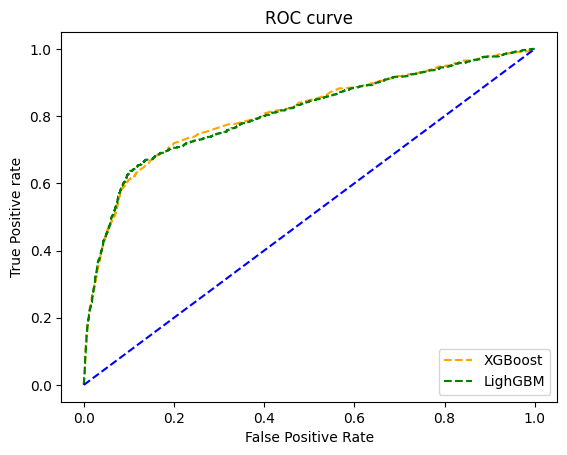

In [72]:
# plot roc curves
plt.plot(fpr_x, tpr_x, linestyle='--',color='orange', label='XGBoost')
plt.plot(fpr_l, tpr_l, linestyle='--',color='green', label='LighGBM')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='lower right')
plt.show();

In [73]:
# auc scores
auc_score_xgb = roc_auc_score(y_test, probs_xgb)
auc_score_lgb = roc_auc_score(y_test, probs_lgb)

In [74]:
print("XGBoost AUC score :",np.round(auc_score_xgb,decimals = 2))
print("LightGBM AUC score :",np.round(auc_score_lgb,decimals = 2))
print("XGBoost Balanced Accuracy Score :",np.round(balanced_accuracy_score(y_test, y_pred_xgb),decimals = 2))
print("LightGBM Balanced Accuracy Score :",np.round(balanced_accuracy_score(y_test, y_pred_lgb),decimals = 2))

XGBoost AUC score : 0.81
LightGBM AUC score : 0.81
XGBoost Balanced Accuracy Score : 0.75
LightGBM Balanced Accuracy Score : 0.76


In [75]:
# As seen, XGBoost and LightGBM model very similiar performance. As LightGBM model is faster to train we

print("XGBoost Classification Report:")
print()
print(classification_report(y_test, y_pred_xgb, target_names=labels))
print("LightGBM Classification Report:")
print()
print(classification_report(y_test, y_pred_lgb, target_names=labels))

XGBoost Classification Report:

               precision    recall  f1-score   support

Did not leave       0.95      0.91      0.93      7310
         Left       0.46      0.59      0.52       928

     accuracy                           0.88      8238
    macro avg       0.70      0.75      0.72      8238
 weighted avg       0.89      0.88      0.88      8238

LightGBM Classification Report:

               precision    recall  f1-score   support

Did not leave       0.95      0.91      0.93      7310
         Left       0.45      0.61      0.52       928

     accuracy                           0.87      8238
    macro avg       0.70      0.76      0.72      8238
 weighted avg       0.89      0.87      0.88      8238



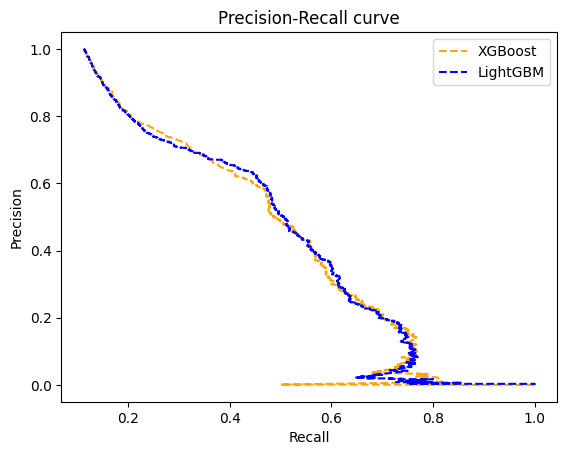

In [76]:
# roc curve for models
precision_xgb, recall_xgb, thresh_xgb = precision_recall_curve(y_test, probs_xgb, pos_label=1)
precision_lgb, recall_lgb, thresh_lgb = precision_recall_curve(y_test, probs_lgb, pos_label=1)

# plot roc curves
plt.plot(precision_xgb, recall_xgb, linestyle='--',color='orange', label='XGBoost')
plt.plot(precision_lgb, recall_lgb, linestyle='--',color='blue', label='LightGBM')

# title
plt.title('Precision-Recall curve')
# x label
plt.xlabel('Recall')
# y label
plt.ylabel('Precision')

plt.legend(loc='best')
plt.show();

**The XGBoost and LightGBM models exhibit very similar performance.**

1. Both the XGBoost and LightGBM models yield an average F1 score of 0.70.. .

2. Tuning LightGBM hyperparameters takes 0.56 minutes, whereas tuning XGBoost hyperparameters takes 19.04 minutes.

**Result : Since both models exhibit very similar performance, we will proceed with the LightGBM model due to its faster training speed.**

# 10. SHAP : Model Interpretation

In [78]:
shap.initjs()

In [79]:
d_train = lgb.Dataset(X_train, label=y_train)
d_val = lgb.Dataset(X_val, label=y_val)
d_test = lgb.Dataset(X_test, label=y_test)

In [80]:
random_cv_lgb.best_params_

{'subsample': 0.5,
 'scale_pos_weight': 4,
 'reg_lambda': 20.0,
 'reg_alpha': 20.0,
 'n_estimators': 5000,
 'max_depth': 6,
 'learning_rate': 0.05}

In [81]:
params = {
    "learning_rate": 0.08,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "subsample" : 0.8,
    "scale_pos_weight" : 3,
    "reg_lambda" : 10,
    "reg_alpha" : 20,
    "max_depth" : 5,
    "verbose": -1,
}

final_model = lgb.train(params, d_train, 5000, valid_sets=[d_val])

In [101]:
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_train)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


**Interpretation of force plot** :The force plot indicates that when macroeconomic indicators such as consumer price index (cons.price.idx) and the number of employed individuals (nr.employed) are high, the log odds of depositing money increase. Additionally, if a customer is single, they are less likely to deposit money. 

In [105]:
# Force plot for first individual
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_train.iloc[0,:])

In [103]:
# Force plot for 1000 individuals
shap.force_plot(explainer.expected_value[1], shap_values[1][:1000,:], X_train.iloc[:1000,:])

In [106]:
# Absolute Mean SHAP : It tells us , on average, how much each variable impacts the target
shap.summary_plot(shap_values, X_train)